practice_01.ipynb

# Practice : Cat VS Dog

Here, we’re going to see if the neuron we created in the notebook can already try to classify images.  
We have pictures of dogs and cats, and the goal is to correctly sort them into the "dog" or "cat" class.

To do this, we’ll use **two datasets**: one for **training** the neuron, and one for **testing** it.

> ### Why do we use two datasets?
>
> If we trained and tested on the same data, the neuron might just *memorize* the answers without really learning how to generalize.  
> 
> By training on one set and testing on a different one, we check if the neuron truly **understands** how to recognize *new, unseen* images.
>
> It's just like preparing for an exam: practicing with exercises is great, but the real test is solving **new problems** you haven’t seen before!




In [22]:
#%pip install matplotlib
#%pip install h5py
#%pip install nbimporter
import matplotlib.pyplot as plt
import nbimporter
from utilities import *
from practice_00 import artificial_neuron, initialisation, model, gradients,
                        update, predict, accuracy_score
from sklearn.metrics import accuracy_score

In [2]:
X_train, y_train, X_test, y_test = load_data()

In [3]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print(np.unique(y_train, return_counts=True))

X_train shape:  (1000, 64, 64)
y_train shape:  (1000, 1)
(array([0., 1.]), array([500, 500]))


### For the training dataset:

We have 1,000 photos, each of size **64×64 pixels**.

There are also 1,000 labels (one label per photo), either for a **cat** (label `0`) or a **dog** (label `1`).

There are **500 photos** for each label, so the dataset is balanced between cats and dogs.


In [4]:
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(np.unique(y_test, return_counts=True))

X_test shape:  (200, 64, 64)
y_test shape:  (200, 1)
(array([0., 1.]), array([100, 100]))


### For the test dataset:

Same procedure: we have **200 photos**, with **two labels** (cats and dogs).

There are **100 photos** for each label, so the test set is also balanced.


## Let's display the first 10 photos from the dataset.


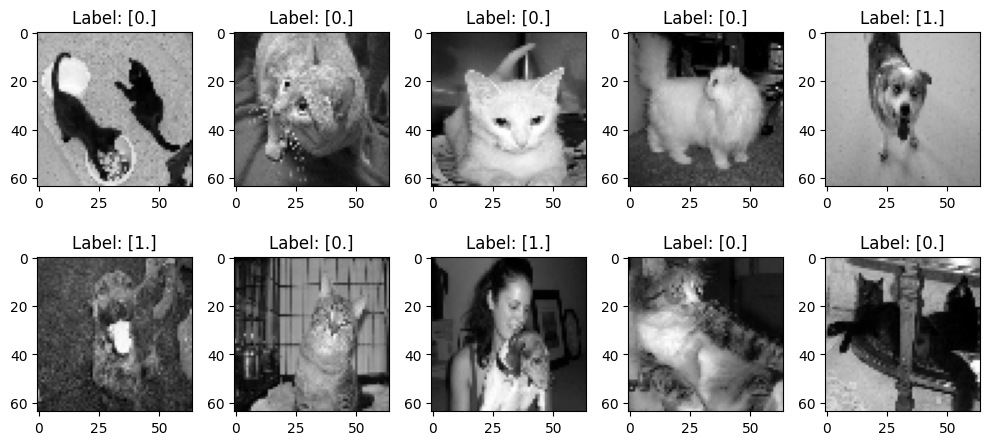

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.tight_layout()
plt.show()

## How do we feed a photo into our artificial neuron model?

A good question you might be asking right now is: *How do we actually provide a photo to our neuron model?*

**Easy.**  
We treat each pixel of the photo as a variable. Since each photo is **64×64 pixels**, that gives us **64×64 = 4096 variables**.

By scanning the pixels from left to right and top to bottom, we build a dataset like this for each photo:  $X = (x_1, x_2, \dots, x_{4096})$ where each variable is a pixel.

From there, it's just like in the previous notebook: we apply a mathematical model to $X$, and predict whether the photo is a **cat** or a **dog**.


## Steps to follow to make a prediction:

1. **Normalize the dataset.**  
   Each pixel is coded on 8 bits. Since $2^8 = 256$, we need to normalize the pixel values between 0 and 1.

2. **Transform each image (64×64 pixels)**  
   into a sequence of variables:  
   $X = (x_1, x_2, \dots, x_{4096})$

3. **Train the model**  
   on the **train_set**.

4. **Evaluate the model**  
   on the **test_set**.


# 1&2. Let's tranform and normalize at the same time
 
Each pixel value originally goes from 0 to 255 (since it's coded on 8 bits).  
To normalize, we simply **divide every pixel value by 255** so that all values are between **0 and 1**.

At the same time, we **reshape** each image:  
Instead of a 64×64 grid for each image, we flatten it into a **single vector** with **4096 variables**.


We want to do something like this:


In [6]:
X_reshaped = []
for image in X_train:
    image_flat = []
    for row in image:
        for pixel in row:
            image_flat.append(pixel / 255)
    X_reshaped.append(image_flat)

X_reshaped = np.array(X_reshaped)
print(X_reshaped.shape)

(1000, 4096)


We can observe two things:

1. We have **normalized** each pixel.
2. We have a **1000 x 4096 input array**, where:
   - Each **row** represents an image (1000 images in total).
   - Each **i-th column** represents the i-th pixel across all 1000 images.


But a **data science way** to do this is by directly calling a function to perform the reshape:


In [7]:
X_train_reshape = X_train.reshape(X_train.shape[0], 
                                  X_train.shape[1] * X_train.shape[2])

For those who are familiar with Python:


In [8]:
# normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(X_train_reshape[0])

(1000, 4096)
(200, 4096)
[0.6431373  0.68235296 0.6392157  ... 0.34117648 0.7058824  0.15294118]


## Why is it important to normalize our data in data science?

Imagine you're in a band, and you're doing a sound check before a concert. Each instrument — drums, guitar, vocals — plays its part. But if the drums are way louder than everything else, they overpower the mix. That doesn't mean the drums are more important — every instrument has its role to play. 

In data science, it’s the same: if one feature has bigger numbers than the others, the model might "hear" it more, but that doesn’t make it more important than the rest. Normalization is like adjusting the sound levels so that every instrument — or feature — is balanced. That way, the model listens to the whole band, not just the loudest player.

### In one sentence: we normalize to be fair.

## 3. Now it's time to train the model on the training data.


practice_00.ipynb:3: RuntimeWarning: divide by zero encountered in log
  {
practice_00.ipynb:3: RuntimeWarning: invalid value encountered in multiply
  {


accuracy score : 0.499
final set parameters : [[ 1.34766292]
 [ 1.58128026]
 [-0.85694915]
 ...
 [ 1.94211888]
 [ 1.58980616]
 [-0.50367724]] [-1.46349302]


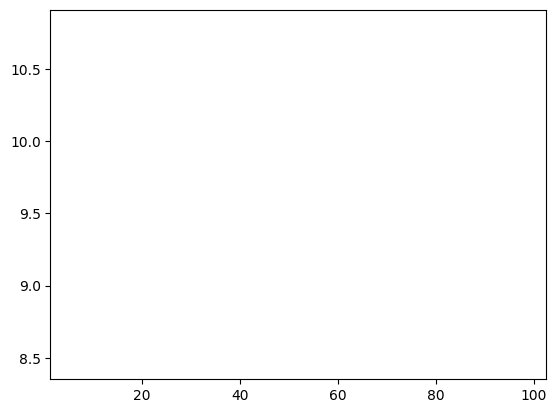

In [9]:
W, b = artificial_neuron(X_train_reshape, y_train, learning_rate=0.1, num_iter=100)

We’re getting an error that says we’re dividing by 0 inside a log function.  

Let’s break it down:

There’s a `log` involved in the loss function, which itself depends on `A`, and `A` is based on `Z` through an **exponential**.  
Now, remember: the exponential function grows *extremely* fast.  
Even a value around 200 can be enough to completely blow up the computation (way beyond what a computer can handle without overflowing).

Long story short:  
In data science, a very common trick to fix this is to add a tiny constant (called **epsilon**, usually something like 1e-15) to avoid taking the log of zero.  
It’s small enough that it doesn’t mess up the results but big enough to avoid errors.

Let’s see it in code to make it super clear:

In [10]:
# the problem is in log_loss, look at now in the log :
def log_loss(A, y):
    m = len(y)
    epsilon = 10e-15
    loss = -1/m * np.sum(y * np.log(A + epsilon) 
                 + (1 - y) * np.log(1 - A + epsilon))
    return loss

def predict(X, W, b):
    A = model(X, W, b)
    #print(A)
    return A >= 0.5

def new_artificial_neuron(X, y, learning_rate=0.1, num_iter=100):
    # initializer parameters
    W, b = initialisation(X)

    # error visualization : plotting the loss at each iteration
    loss = []

    for i in range(num_iter):
        A = model(X, W, b)
        loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)

    # Loop finished, best set parameters (W, b)

    y_pred = predict(X, W, b)
    print('accuracy score :', accuracy_score(y, y_pred))

    plt.plot(loss)
    plt.show

Let's try again — same neuron, but now with the regularized log loss

accuracy score : 0.508


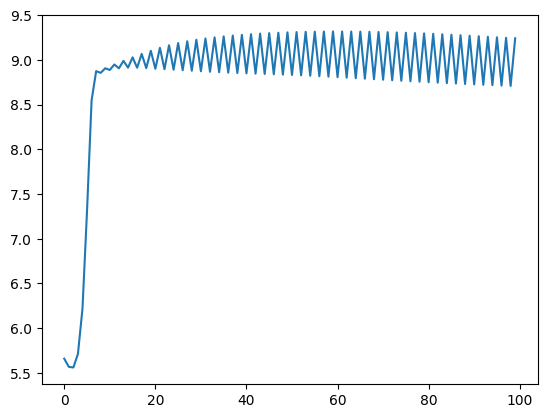

In [11]:
new_artificial_neuron(X_train_reshape, y_train)

### It works, but the behavior is unstable

The model runs, but the results are messy.  
This instability comes from **hyperparameters**, which are just as important as normalization.

We’ll talk about this more in the next part!

## Hyperparameters and Diagnosis

Hyperparameters are called like that because they are **hyper important**.  
They are the only parameters we can use to **control our neuron** once it is built.

For example, we can decide **how fast it learns** with the **learning rate**.  
But be careful: if you go faster, you lose precision.

We can also decide **how many lessons** the neuron is allowed to have, with the **number of iterations** in the learning loop: this is called an **epoch**.

Again, be careful:  
- If you give too few lessons, the neuron won't have enough time to learn.  
- If you give too many lessons, you will **confuse its mind**, exactly like what happens to us humans.


### Learning Rate

The **learning rate** is the speed at which the neuron learns.  
Remember, it's directly related to the **gradient**.  
It controls how much influence the gradient has on the updates to the parameters at each epoch.  

The gradient itself tells the parameters which direction to take to minimize the cost function.  
So, the learning rate determines **how important that direction is**.  

But if the learning rate is too high, we will **overshoot** the optimal parameter set every time.  
Then the new direction will tell us to go back, but we’ll overshoot again, back and forth, over and over.  
It creates a kind of chaotic behavior instead of smooth progress.


It looks like this is exactly what's happening.  
Let’s try to **fine-tune** the learning rate and **reduce the learning speed** from 0.1 to 0.01.  
By doing this, we should make the updates smaller and smoother, avoiding the overshooting problem.

accuracy score : 0.511


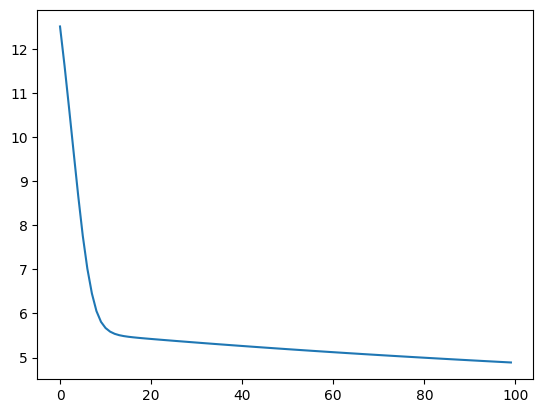

In [12]:
new_artificial_neuron(X_train_reshape, y_train, learning_rate=0.01, num_iter=100)

Not bad. Let’s try increasing the number of epochs a bit as well.


accuracy score : 0.538


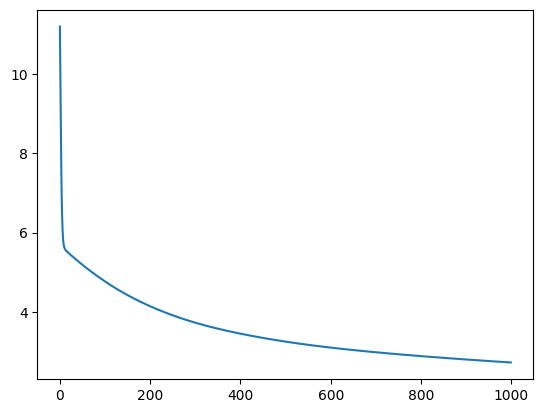

In [13]:
new_artificial_neuron(X_train_reshape, y_train, learning_rate=0.01, num_iter=1000)

Okay, this is all well and good, but how can we tell if the neuron is properly trained? Sure, it has learned well, but is it ready for the exam?  
One way to judge this is by looking at the accuracy curve at each epoch. Let’s modify our neuron a bit then:

In [21]:
#%pip install tqdm
from tqdm import tqdm 

In [17]:
def new_artificial_neuron(X, y, learning_rate=0.01, num_iter=10000):
    # initializer parameters
    W, b = initialisation(X)

    # error visualization : plotting the loss at each iteration
    loss = []
    acc = []

    for i in tqdm(range(num_iter)): # progression bar
        A = model(X, W, b)

        if i % 50 == 0: # reduce computing time
            loss.append(log_loss(A, y))
            y_pred = predict(X, W, b)
            acc.append(accuracy_score(y, y_pred))

        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
        
    # Loop finished, best set parameters (W, b)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(loss)
    plt.subplot(1,2,2)
    plt.plot(acc)
    plt.show

100%|██████████| 10000/10000 [01:00<00:00, 164.54it/s]


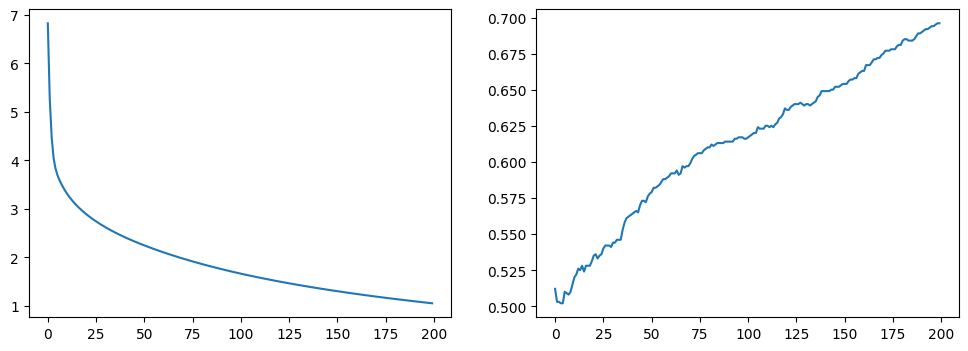

In [18]:
new_artificial_neuron(X_train_reshape, y_train)

We can see that as the error decreases (as the neuron learns), it becomes more and more accurate, which is good. But at this point, you should be thinking something.  

Why does the learning curve seem to plateau, finding its minimum, while the performance curve continues to evolve, increasing?  

At this point, one of the most likely answers is that the model might be entering into **overfitting**.


**Overfitting** happens when your model can no longer generalize. It focuses so much on the examples from the training set (it focuses so much on the exercises done in class) that it loses its ability to make good predictions on a new set of data (it loses the ability to answer correctly on the exam, which is a bit different).
 
It’s exactly like a human. You need to maintain perspective on the exercises, focusing more on the method rather than the specific solution of each exercise in order to adapt on exam day.


So, how can we tell if this is the issue?  
Let’s try to **predict on another dataset**, like the **test set**, for example!

In [19]:
def artificial_neuron(X_train, y_train, X_test, y_test, learning_rate = 0.1, n_iter = 100):
    # initialisation W, b
    W, b = initialisation(X_train)

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for i in tqdm(range(n_iter)):
        A = model(X_train, W, b)

        if i % 10 == 0:
            # Train
            train_loss.append(log_loss(A, y_train))
            y_pred = predict(X_train, W, b)
            train_acc.append(accuracy_score(y_train, y_pred))

            # Test
            A_test = model(X_test, W, b)
            test_loss.append(log_loss(A_test, y_test))
            y_pred = predict(X_test, W, b)
            test_acc.append(accuracy_score(y_test, y_pred))

        # mise a jour
        dW, db = gradients(A, X_train, y_train)
        W, b = update(dW, db, W, b, learning_rate)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.legend()
    plt.show()

    return (W, b)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:01<00:00, 161.45it/s]


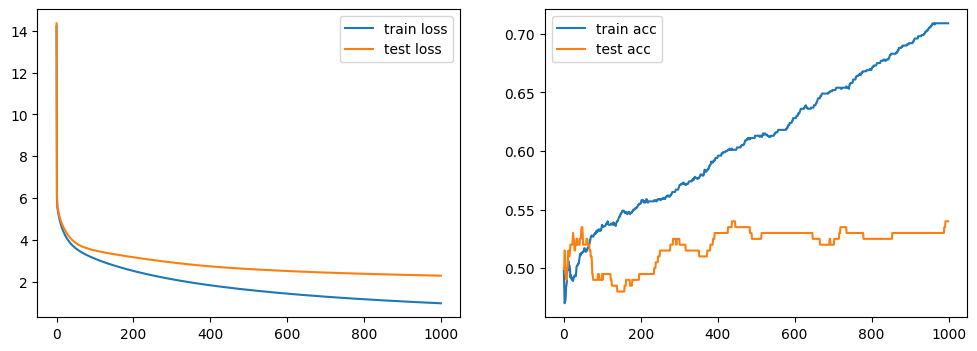

In [20]:
W, b = artificial_neuron(X_train_reshape, y_train, X_test_reshape, y_test, learning_rate = 0.01, n_iter=10000)


### Detecting Overfitting

We can see a clear difference in how the neuron performs on the train and test data.  
This clearly indicates that we have an overfitting model.

There’s a gap in the error between the train set and the test set, which shows that the model makes **much more error** on the test set than on the train set.  
We see the same thing with performance: the model keeps training and improving its performance on the train set, but its ability to generalize what it learned is **very poor**, as we can see on the test set.


### How to fix this problem?

1) **Give the machine more data** so it learns from more varied examples.  
2) **Reduce the number of variables** (features) to make the model simpler.  
3) Use **regularization techniques** (L1 or L2 penalty) to prevent overfitting.

However, here, these solutions won't really improve the model's performance, because the reality is that **our model is way too simple**.

And yes, I remind you: so far, we’ve only been using **one neuron**!  
And a single neuron is a **linear model**.  
This means we can only use it for problems that can be separated linearly.


### Improving the Model

We’re going to add more neurons, creating an **artificial neural network**.
